# Climate Masks

In [1]:
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

## Functions

In [2]:
def plot_z(z, lat, lon, zlabel, coastlines=False, output=False, **kwargs):
    """
    Plot data.

    Parameters
    ----------
    z : array
        the data (unsnaked)
        
    lat : array
        of latitude
        
    lon : array
        of longitude
        
    zlabel : string
        label for the colorbar
        
    coastlines : boolean
        set whether coastlines will be drawn (default False)
        
    output : boolean
        if true, return the figure and axis handles (default False)
        
    **kwargs
        passed to plt.pcolormesh()
    """
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=ccrs.Mollweide())
    if coastlines:
        ax.coastlines()

    #im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree(), **kwargs)
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree(), **kwargs)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(zlabel, rotation=270, labelpad=20)

    if output!=False:
        return fig, ax

## Modern Temperature

Read in data:

In [3]:
path_to_CRU_TS = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/Modern_Climate/raw_data/temperature/'

CRU_TS_60s = Dataset(path_to_CRU_TS + 'cru_ts4.03.1961.1970.tmp.dat.nc')
CRU_TS_70s = Dataset(path_to_CRU_TS + 'cru_ts4.03.1971.1980.tmp.dat.nc')
CRU_TS_80s = Dataset(path_to_CRU_TS + 'cru_ts4.03.1981.1990.tmp.dat.nc')

lat = CRU_TS_60s.variables['lat'][:].data
lon = CRU_TS_60s.variables['lon'][:].data

Get time average each dataset individually, then together:

In [4]:
# pull out the temperature data
CRU_TS_60s_temp = CRU_TS_60s.variables['tmp'][:,:,:].copy()
CRU_TS_60s_temp[CRU_TS_60s_temp>1e36] = np.nan

CRU_TS_70s_temp = CRU_TS_70s.variables['tmp'][:,:,:].copy()
CRU_TS_70s_temp[CRU_TS_70s_temp>1e36] = np.nan

CRU_TS_80s_temp = CRU_TS_80s.variables['tmp'][:,:,:].copy()
CRU_TS_80s_temp[CRU_TS_80s_temp>1e36] = np.nan

# get the mean for each dataset
CRU_TS_60s_temp = np.nanmean(CRU_TS_60s_temp, axis=0)
CRU_TS_70s_temp = np.nanmean(CRU_TS_70s_temp, axis=0)
CRU_TS_80s_temp = np.nanmean(CRU_TS_80s_temp, axis=0)

# get the total mean
CRU_TS_temp = np.nanmean(np.array([CRU_TS_60s_temp,CRU_TS_70s_temp,CRU_TS_80s_temp]), axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


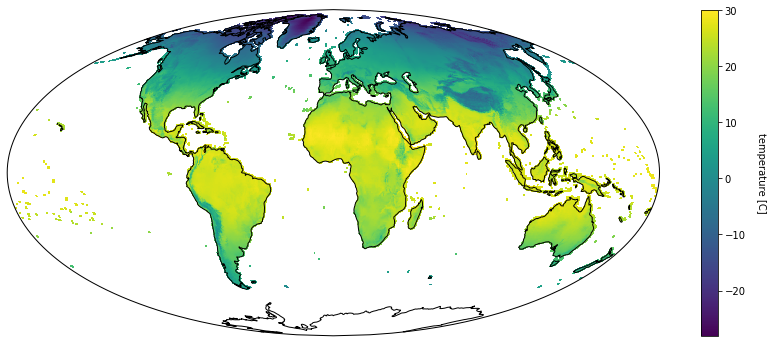

In [5]:
plot_z(CRU_TS_temp, lat, lon, 'temperature [C]', coastlines=True)

In [6]:
np.shape(CRU_TS_temp)

(360, 720)

Output to a netCDF:

In [7]:
# initialize netCDF
modern_temp_nc = Dataset('../Output/modern_temp.nc', 'w', format='NETCDF4')
modern_temp_nc.description = 'Modern temperature data from CRU TS v4.03.'

# create dimensions
modern_temp_nc.createDimension('lon', 720)
modern_temp_nc.createDimension('lat', 360)

# initialize variables
lon_var = modern_temp_nc.createVariable('lon', 'f', ('lon',))
lat_var = modern_temp_nc.createVariable('lat', 'f', ('lat',))
tmp_var = modern_temp_nc.createVariable('tmp', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
tmp_var.long_name = 'temperature'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
tmp_var.units = 'C'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon
lat_var[:] = lat

CRU_TS_temp_masked = CRU_TS_temp.copy()
CRU_TS_temp_masked[np.isnan(CRU_TS_temp)] = 1e36
tmp_var[:,:] = CRU_TS_temp_masked
    
modern_temp_nc.close()

## Modern Runoff

From the top of the .grd file:

```
ncols         720
nrows         277
xllcorner     -180
yllcorner     -55.5
cellsize      0.5
NODATA_value  -9999
```

Read in data:

In [8]:
# read in the .grd file
cmp = np.loadtxt('../Input/cmp_ro.grd', skiprows=6)

# flip it to match the order of latitudes in the temperature file
cmp = np.flipud(cmp)

# initialize a matrix full of the fill value
cmp_runoff = np.ones(np.shape(CRU_TS_temp)) * -9999

# put the runoff data in the right spot
cmp_runoff[np.where((lat>-55.5) & (lat<(-55.5+277*0.5)))[0]] = cmp

# get rid of fill values
cmp_runoff[(cmp_runoff<0)&(cmp_runoff>-1000)] = 0
cmp_runoff[cmp_runoff==-9999] = np.nan

# convert from mm/yr to m/yr
cmp_runoff = cmp_runoff/1000

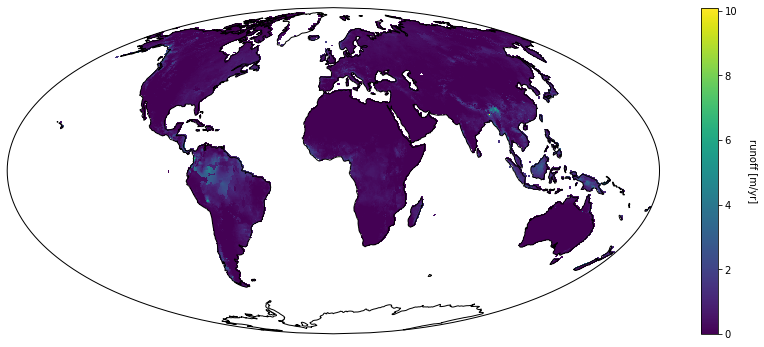

In [9]:
plot_z(cmp_runoff, lat, lon, 'runoff [m/yr]', coastlines=True)

Output to a netCDF:

In [10]:
# initialize netCDF
modern_runoff_nc = Dataset('../Output/modern_runoff.nc', 'w', format='NETCDF4')
modern_runoff_nc.description = 'Modern runoff data from UNH/GRDC composite runoff fields v1.0.'

# create dimensions
modern_runoff_nc.createDimension('lon', 720)
modern_runoff_nc.createDimension('lat', 360)

# initialize variables
lon_var = modern_runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = modern_runoff_nc.createVariable('lat', 'f', ('lat',))
rnf_var = modern_runoff_nc.createVariable('rnf', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon
lat_var[:] = lat

cmp_runoff_masked = cmp_runoff.copy()
cmp_runoff_masked[np.isnan(cmp_runoff_masked)] = 1e36
rnf_var[:,:] = cmp_runoff_masked
    
modern_runoff_nc.close()

Old runoff data:

In [11]:
old_modern_runoff_nc = Dataset('../Input/runoff1x1.nc')
old_modern_runoff = old_modern_runoff_nc.variables['runoff'][:,:].data
old_modern_runoff[old_modern_runoff>1e36] = np.nan

In [12]:
# increase resolution
old_modern_runoff_interp = np.zeros((360, 720))
for i in range(len(old_modern_runoff_nc.variables['lat'][:])):
    for j in range(len(old_modern_runoff_nc.variables['lon'][:])):
        old_modern_runoff_interp[i*2:(i+1)*2,j*2:(j+1)*2] = old_modern_runoff[i,j]

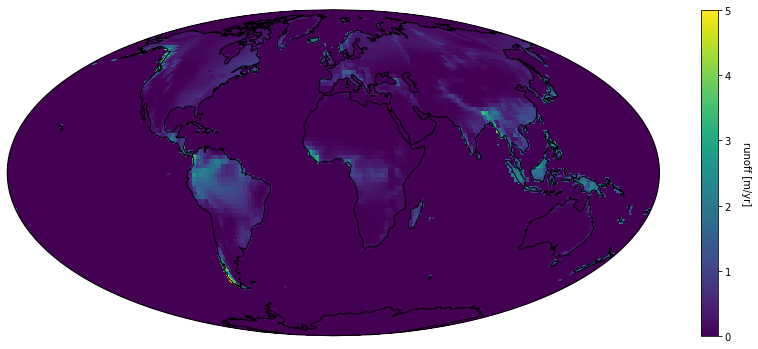

In [13]:
plot_z(old_modern_runoff_interp, lat, lon,
       'runoff [m/yr]', coastlines=True)

In [14]:
# initialize netCDF
old_modern_runoff_nc = Dataset('../Output/old_modern_runoff.nc', 'w', format='NETCDF4')
old_modern_runoff_nc.description = '1x1 degree modern runoff data from Yves.'

# create dimensions
old_modern_runoff_nc.createDimension('lon', 720)
old_modern_runoff_nc.createDimension('lat', 360)

# initialize variables
lon_var = old_modern_runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = old_modern_runoff_nc.createVariable('lat', 'f', ('lat',))
rnf_var = old_modern_runoff_nc.createVariable('rnf', 'f', ('lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'

# fill variables
lon_var[:] = lon
lat_var[:] = lat

old_modern_runoff_interp_masked = old_modern_runoff_interp.copy()
old_modern_runoff_interp_masked[np.isnan(old_modern_runoff_interp_masked)] = 1e36
rnf_var[:,:] = old_modern_runoff_interp_masked
    
old_modern_runoff_nc.close()

Comparison:

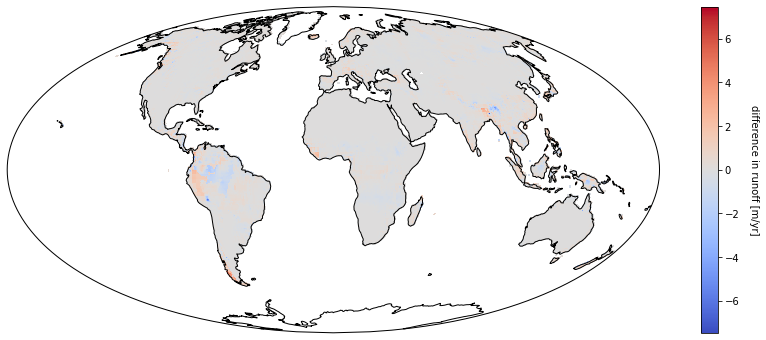

In [15]:
modern_runoff_diff = old_modern_runoff_interp - cmp_runoff

plot_z(modern_runoff_diff, lat, lon,
       'difference in runoff [m/yr]', coastlines=True,
       vmin=np.nanmin(modern_runoff_diff), vmax=np.abs(np.nanmin(modern_runoff_diff)), cmap='coolwarm')

## GFDL CM2.0 experiments

The GFDL CM2.0 experiments cover a good range of CO$_2$ values from pre-industrial to 4x pre-industrial that were run for long time periods such that we can take means of climatology spanning 100 years or more. Can use run-off and precipitation from:
- 1860 control (d2)
- +1%/yr to 2x (i1)
- +1%/yr to 4x (j1)
Details regarding these experiments are below. A strength of using these three experiments is that they all keep the same conditions for things other than CO2: *all non-CO2 forcing agents (CH4, N2O, halons, tropospheric and stratospheric O3, tropospheric sulfates, black and organic carbon, dust, sea salt, solar irradiance, and the distribution of land cover types) were held constant at values representative of year 1860*. The other models vary these other parameters. Since we are interested in CO2 forcing alone these experiments are a good set to work with and nicely space a broad range.

<img src="XMGR_OCT2004-2.png">

**1860 control (d2)**

CO2: 286 ppmv 
*Let's use years 200 to 300 of the model*

> "GFDL experiment name = CM2Q_Control-1860_d2. PCMDI experiment name = PIcntrl (run1). Initial conditions for this experiment were derived from a multi-step process. First, an atmosphere + land surface model was spun up with forcing agents at levels representative of the late 20th century. Second, the spun up atmosphere + land surface model was coupled to an ocean + sea ice model. Initial conditions for sea ice, ocean potential temperature and salinity were derived from late 20th century observations. Forcing agents consistent with year 1860 were applied to the coupled model which was integrated for a ~300 year adjustment period. Year 1 of the archived CM2Q_Control-1860_d2 experiment data begins at the end of this adjustment period. CM2Q_Control-1860_d2 forcing agents representative of conditions circa-1860 include the well-mixed greenhouse gases (CO2, CH4, N2O), tropospheric and stratospheric O3, tropospheric sulfates, black and organic carbon, dust, sea salt, solar irradiance, and the distribution of land cover types. The direct effect of tropospheric aerosols is calculated by the model, but not the indirect effects."

ts_A0.0001-0500.nc
mrro_A0.0001-0500.nc

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q_Control-1860_d2/

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q_Control-1860_d2/pp/land/ts/annual/mrro_A0.0001-0500.nc

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q_Control-1860_d2/pp/atmos/ts/annual/ts_A0.0001-0500.nc

**CM2Q-d2_1PctTo2x_i1**

CO2: 572 ppmv
*Let's use years 180 to 280 of the model*

> 'GFDL experiment name = CM2Q-d2_1PctTo2x_i1. PCMDI experiment name = 1%to2x (run1). Initial conditions for this experiment were taken from 1 January of year 1 of the 1860 control model experiment named CM2Q_Control-1860_d2. In the CM2Q-d2_1PctTo2x_i1 experiment atmospheric CO2 levels were prescribed to increase from their initial mixing ratio level of 286.05 ppmv at a compounded rate of +1 percent per year until year 70 (the point of doubling). CO2 levels were held constant at 572.11 ppmv from year 71 through the end of the 280 year long experiment. For the entire 280 year duration of the experiment, all non-CO2 forcing agents (CH4, N2O, halons, tropospheric and stratospheric O3, tropospheric sulfates, black and organic carbon, dust, sea salt, solar irradiance, and the distribution of land cover types) were held constant at values representative of year 1860.' 

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo2x_i1/

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo2x_i1/pp/land/ts/annual/mrro_A0.0001-0280.nc

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo2x_i1/pp/atmos/ts/annual/ts_A0.0001-0280.nc

**CM2Q-d2_1PctTo4x_j1**

CO2: 1144 ppmv
*Let's use years 200 to 300 of the model*

> GFDL experiment name = CM2Q-d2_1PctTo4x_j1. PCMDI experiment name = 
1%to4x (run1). Initial conditions for this experiment were taken from 
1 January of year 41 of the 1860 control model experiment named 
CM2Q_Control-1860_d2. In the CM2Q-d2_1PctTo4x_j1 experiment 
atmospheric CO2 levels were prescribed to increase from their initial 
mixing ratio level of 286.05 ppmv at a compounded rate of +1 percent 
per year until year 140 (the point of quadrupling). CO2 levels were 
held constant at 1144.21 ppmv from year 141 through the end of the 300 
year long experiment. For the entire 300 year duration of the 
experiment, all non-CO2 forcing agents (CH4, N2O, halons, tropospheric 
and stratospheric O3, tropospheric sulfates, black and organic carbon, 
dust, sea salt, solar irradiance, and the distribution of land cover 
types) were held constant at values representative of year 1860.

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo4x_j1/

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo4x_j1/pp/land/ts/annual/mrro_A0.0001-0300.nc

http://nomads.gfdl.noaa.gov/dods-data/gfdl_cm2_0/CM2Q-d2_1PctTo4x_j1/pp/atmos/ts/annual/ts_A0.0001-0300.nc

### Import Files

In [16]:
CO2s = np.array([286,572,1144])

mrro_0286 = Dataset('../Input/mrro_A0.0001-0500_286ppm.nc')
mrro_0572 = Dataset('../Input/mrro_A0.0001-0280_572ppm.nc')
mrro_1144 = Dataset('../Input/mrro_A0.0001-0300_1144ppm.nc')

ts_0286 = Dataset('../Input/ts_A0.0001-0500_286ppm.nc')
ts_0572 = Dataset('../Input/ts_A0.0001-0280_572ppm.nc')
ts_1144 = Dataset('../Input/ts_A0.0001-0300_1144ppm.nc')

In [17]:
GFDL_lat = mrro_0286.variables['lat'][:].data
GFDL_lon = mrro_0286.variables['lon'][:].data

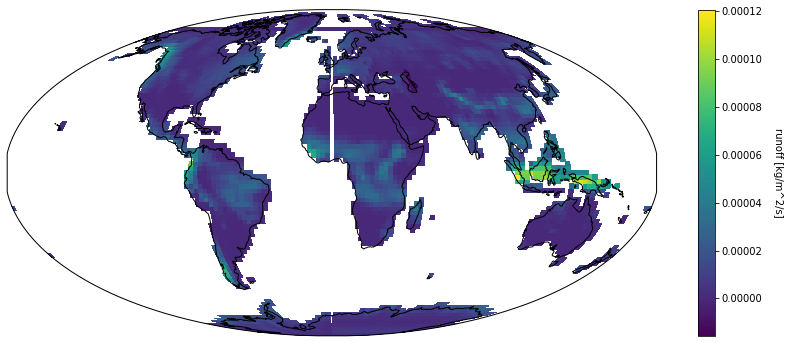

In [18]:
plot_z(mrro_0286.variables['mrro'][0,:,:], GFDL_lat, GFDL_lon,
       'runoff [kg/m^2/s]', coastlines=True)

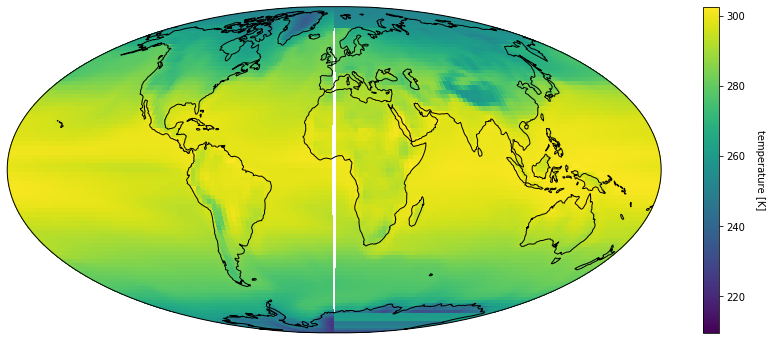

In [19]:
plot_z(ts_0286.variables['ts'][0,:,:], GFDL_lat, GFDL_lon,
       'temperature [K]', coastlines=True)

### 100 Year Means

#### Runoff

In [20]:
print(len(mrro_0286.variables['time']))
print(len(mrro_0572.variables['time']))
print(len(mrro_1144.variables['time']))

500
280
300


In [21]:
mrro_0286_cleaned = mrro_0286.variables['mrro'][(len(mrro_0286.variables['time'])-100):,:,:].copy()
mrro_0286_cleaned[mrro_0286_cleaned<0] = 0
mrro_0286_cleaned[mrro_0286_cleaned>1e10] = np.nan
mrro_0286_annual_mean = np.mean(mrro_0286_cleaned, axis=0)

mrro_0572_cleaned = mrro_0572.variables['mrro'][(len(mrro_0572.variables['time'])-100):,:,:].copy()
mrro_0572_cleaned[mrro_0572_cleaned<0] = 0
mrro_0572_cleaned[mrro_0572_cleaned>1e10] = np.nan
mrro_0572_annual_mean = np.mean(mrro_0572_cleaned, axis=0)

mrro_1144_cleaned = mrro_1144.variables['mrro'][(len(mrro_1144.variables['time'])-100):,:,:].copy()
mrro_1144_cleaned[mrro_1144_cleaned<0] = 0
mrro_1144_cleaned[mrro_1144_cleaned>1e10] = np.nan
mrro_1144_annual_mean = np.mean(mrro_1144_cleaned, axis=0)

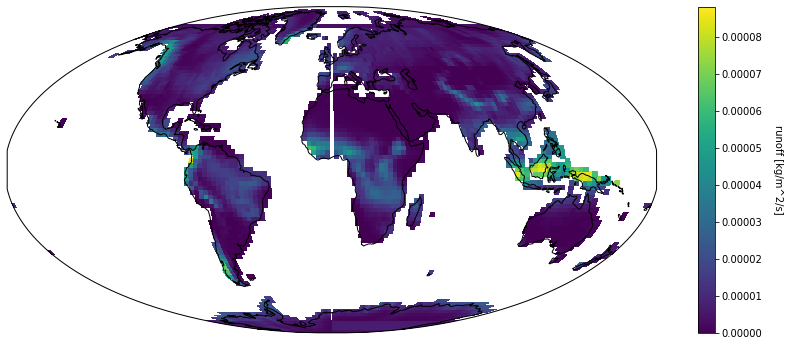

In [22]:
plot_z(mrro_0286_annual_mean, GFDL_lat, GFDL_lon,
       'runoff [kg/m^2/s]', coastlines=True)

#### Temperature

In [23]:
ts_0286_cleaned = ts_0286.variables['ts'][(len(mrro_0286.variables['time'])-100):,:,:].copy()
ts_0286_annual_mean = np.mean(ts_0286_cleaned, axis=0)

ts_0572_cleaned = ts_0572.variables['ts'][(len(mrro_0572.variables['time'])-100):,:,:].copy()
ts_0572_annual_mean = np.mean(ts_0572_cleaned, axis=0)

ts_1144_cleaned = ts_1144.variables['ts'][(len(mrro_1144.variables['time'])-100):,:,:].copy()
ts_1144_annual_mean = np.mean(ts_1144_cleaned, axis=0)

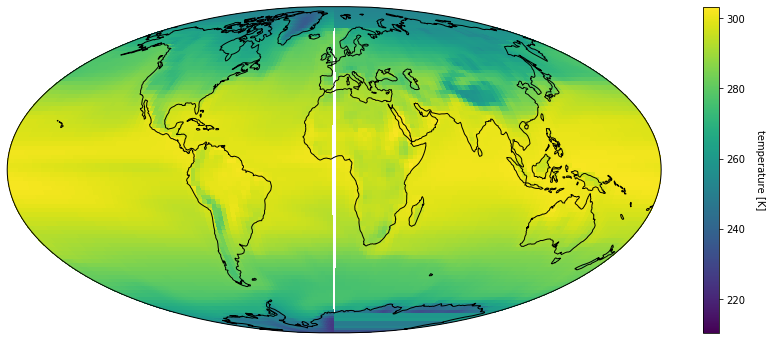

In [24]:
plot_z(ts_0286_annual_mean, GFDL_lat, GFDL_lon,
       'temperature [K]', coastlines=True)

### Change Resolution

First, make the GFDL model output wrap at -180 longitude instead of 0 longitude:

In [25]:
wrap_ind = np.int(len(GFDL_lon)/2)

GFDL_lon_wrap = np.concatenate([GFDL_lon[wrap_ind:],GFDL_lon[:wrap_ind]])
GFDL_lon_wrap[GFDL_lon_wrap>180] = GFDL_lon_wrap[GFDL_lon_wrap>180]-360

mrro_0286_annual_mean_wrap = np.concatenate([mrro_0286_annual_mean[:,wrap_ind:],mrro_0286_annual_mean[:,:wrap_ind]],1)
mrro_0572_annual_mean_wrap = np.concatenate([mrro_0572_annual_mean[:,wrap_ind:],mrro_0572_annual_mean[:,:wrap_ind]],1)
mrro_1144_annual_mean_wrap = np.concatenate([mrro_1144_annual_mean[:,wrap_ind:],mrro_1144_annual_mean[:,:wrap_ind]],1)

ts_0286_annual_mean_wrap = np.concatenate([ts_0286_annual_mean[:,wrap_ind:],ts_0286_annual_mean[:,:wrap_ind]],1)
ts_0572_annual_mean_wrap = np.concatenate([ts_0572_annual_mean[:,wrap_ind:],ts_0572_annual_mean[:,:wrap_ind]],1)
ts_1144_annual_mean_wrap = np.concatenate([ts_1144_annual_mean[:,wrap_ind:],ts_1144_annual_mean[:,:wrap_ind]],1)

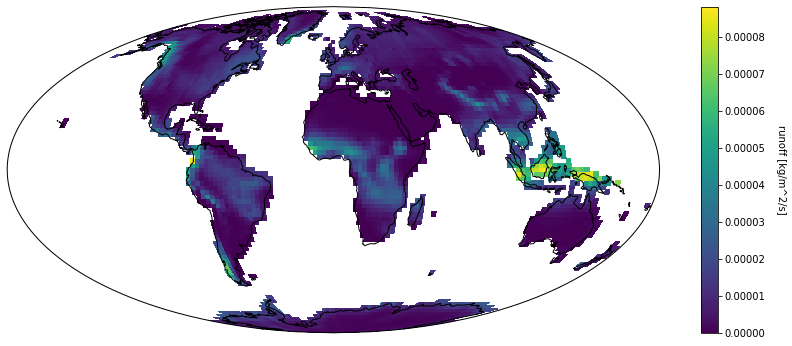

In [26]:
plot_z(mrro_0286_annual_mean_wrap, GFDL_lat, GFDL_lon_wrap,
       'runoff [kg/m^2/s]', coastlines=True)

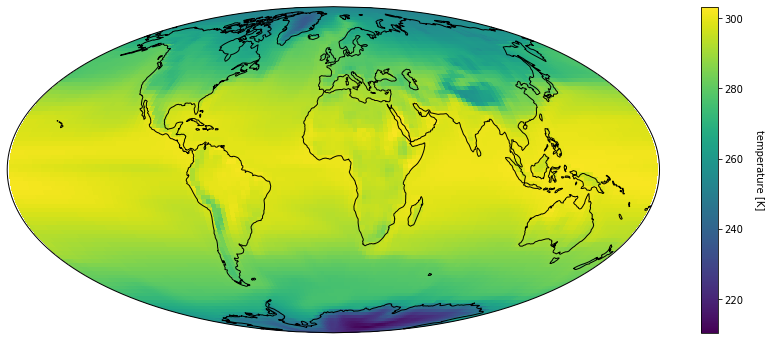

In [27]:
plot_z(ts_0286_annual_mean_wrap, GFDL_lat, GFDL_lon_wrap,
       'temperature [K]', coastlines=True)

Increase the resolution of the GFDL model output by uniformly sampling:

In [28]:
mrro_0286_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        mrro_0286_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = mrro_0286_annual_mean_wrap[i,j]
        
mrro_0572_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        mrro_0572_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = mrro_0572_annual_mean_wrap[i,j]
        
mrro_1144_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        mrro_1144_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = mrro_1144_annual_mean_wrap[i,j]

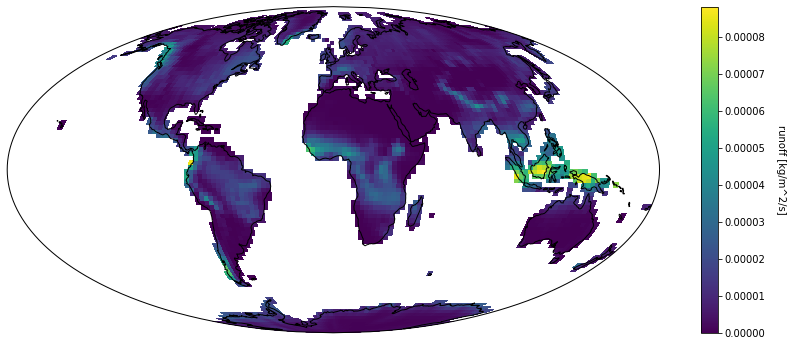

In [29]:
plot_z(mrro_0286_annual_mean_interp, lat, lon,
       'runoff [kg/m^2/s]', coastlines=True)

In [30]:
ts_0286_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        ts_0286_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = ts_0286_annual_mean_wrap[i,j]
        
ts_0572_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        ts_0572_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = ts_0572_annual_mean_wrap[i,j]
        
ts_1144_annual_mean_interp = np.zeros((360, 720))
for i in range(len(GFDL_lat)):
    for j in range(len(GFDL_lon_wrap)):
        ts_1144_annual_mean_interp[i*4:(i+1)*4,j*5:(j+1)*5] = ts_1144_annual_mean_wrap[i,j]

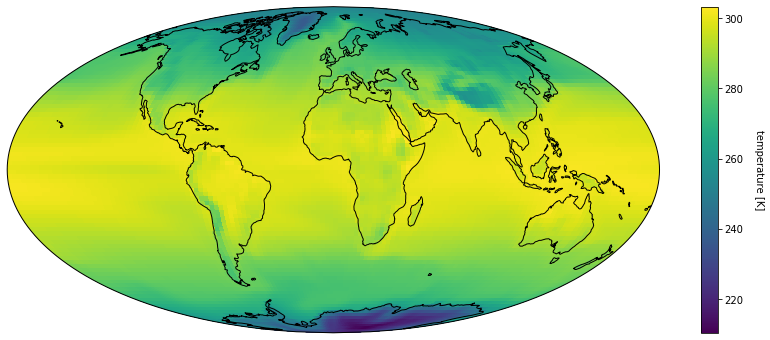

In [31]:
plot_z(ts_0286_annual_mean_interp, lat, lon,
       'temperature [K]', coastlines=True)

### Unit Conversion

Runoff: kg/m2/s to m/yr

1 kg of rain water spread over 1 square meter of surface is 1 mm in thickness

In [32]:
mrro_0286 = mrro_0286_annual_mean_interp * 60*60*24*365 / 1000
mrro_0572 = mrro_0572_annual_mean_interp * 60*60*24*365 / 1000
mrro_1144 = mrro_1144_annual_mean_interp * 60*60*24*365 / 1000

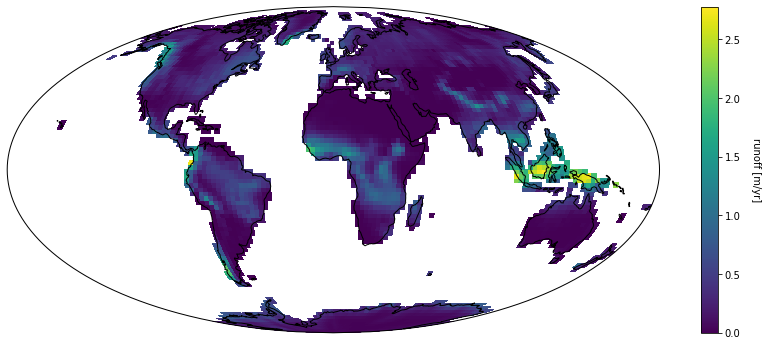

In [33]:
plot_z(mrro_0286, lat, lon,
       'runoff [m/yr]', coastlines=True)

Temperature: K to C

In [34]:
ts_0286 = ts_0286_annual_mean_interp - 273.15
ts_0572 = ts_0572_annual_mean_interp - 273.15
ts_1144 = ts_1144_annual_mean_interp - 273.15

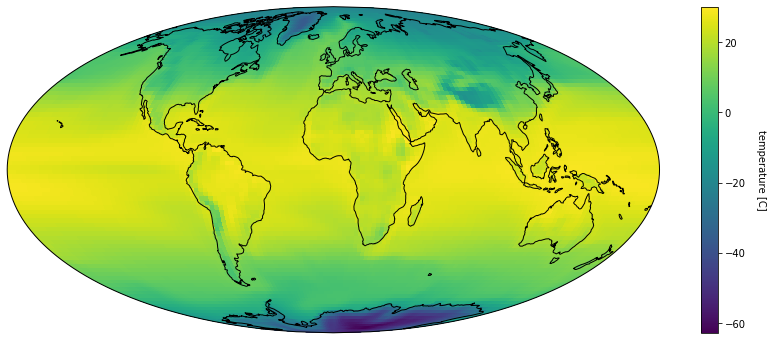

In [35]:
plot_z(ts_0286, lat, lon,
       'temperature [C]', coastlines=True)

### Output

In [36]:
# initialize netCDF
GFDL_runoff_nc = Dataset('../Output/GFDL_runoff.nc', 'w', format='NETCDF4')
GFDL_runoff_nc.description = 'GFDL runoff data interpolated to higher resolution.'

# create dimensions
GFDL_runoff_nc.createDimension('lon', 720)
GFDL_runoff_nc.createDimension('lat', 360)
GFDL_runoff_nc.createDimension('lvl', 3)

# initialize variables
lon_var = GFDL_runoff_nc.createVariable('lon', 'f', ('lon',))
lat_var = GFDL_runoff_nc.createVariable('lat', 'f', ('lat',))
lvl_var = GFDL_runoff_nc.createVariable('lvl', 'f', ('lvl',))
rnf_var = GFDL_runoff_nc.createVariable('rnf', 'f', ('lvl','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lvl_var.long_name = 'CO2'
rnf_var.long_name = 'runoff'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lvl_var.units = 'ppm'
rnf_var.units = 'm/yr'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lvl_var.axis = 'Z'

# fill variables
lon_var[:] = lon
lat_var[:] = lat
lvl_var[:] = CO2s

mrro_0286_masked = mrro_0286.copy()
mrro_0286_masked[np.isnan(mrro_0286_masked)] = 1e36
rnf_var[0,:,:] = mrro_0286_masked

mrro_0572_masked = mrro_0572.copy()
mrro_0572_masked[np.isnan(mrro_0572_masked)] = 1e36
rnf_var[1,:,:] = mrro_0572_masked

mrro_1144_masked = mrro_1144.copy()
mrro_1144_masked[np.isnan(mrro_1144_masked)] = 1e36
rnf_var[2,:,:] = mrro_1144_masked
    
GFDL_runoff_nc.close()

In [37]:
# initialize netCDF
GFDL_temp_nc = Dataset('../Output/GFDL_temp.nc', 'w', format='NETCDF4')
GFDL_temp_nc.description = 'GFDL temperature data interpolated to higher resolution.'

# create dimensions
GFDL_temp_nc.createDimension('lon', 720)
GFDL_temp_nc.createDimension('lat', 360)
GFDL_temp_nc.createDimension('lvl', 3)

# initialize variables
lon_var = GFDL_temp_nc.createVariable('lon', 'f', ('lon',))
lat_var = GFDL_temp_nc.createVariable('lat', 'f', ('lat',))
lvl_var = GFDL_temp_nc.createVariable('lvl', 'f', ('lvl',))
tmp_var = GFDL_temp_nc.createVariable('tmp', 'f', ('lvl','lat','lon',), fill_value=1e36)

# attributes
lon_var.long_name = 'longitude'
lat_var.long_name = 'latitude'
lvl_var.long_name = 'CO2'
tmp_var.long_name = 'temperature'

lon_var.units = 'degrees'
lat_var.units = 'degrees'
lvl_var.units = 'ppm'
tmp_var.units = 'C'

lon_var.axis = 'X'
lat_var.axis = 'Y'
lvl_var.axis = 'Z'

# fill variables
lon_var[:] = lon
lat_var[:] = lat
lvl_var[:] = CO2s

ts_0286_masked = ts_0286.copy()
ts_0286_masked[np.isnan(ts_0286_masked)] = 1e36
tmp_var[0,:,:] = ts_0286_masked

ts_0572_masked = ts_0572.copy()
ts_0572_masked[np.isnan(ts_0572_masked)] = 1e36
tmp_var[1,:,:] = ts_0572_masked

ts_1144_masked = ts_1144.copy()
ts_1144_masked[np.isnan(ts_1144_masked)] = 1e36
tmp_var[2,:,:] = ts_1144_masked
    
GFDL_temp_nc.close()